In [1]:
import numpy as np
import pandas as pd
from sklearn import cross_validation, tree, metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
%pylab inline
from sklearn import cross_validation, datasets, svm
from sklearn.cross_validation import KFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

Populating the interactive namespace from numpy and matplotlib


**Start by extracting a larger feature set**

In [2]:
dataset = pd.read_csv('proc_data.csv')
dataset['id'] = dataset['id'].astype(int)

In [3]:
train = dataset.query('type == "train"')         
test = dataset.query('type == "test"')  

In [4]:
features = ['age', 'class', 'fare', 'family_size', 'embarked_at_Q', 'embarked_at_S', 'female', 'in_cabin', 'Master', 'Miss', 'Mrs']
X = train[['age', 'class', 'fare',  'family_size', 'embarked_at_Q', 'embarked_at_S', 'female', 'in_cabin', 'Master', 'Miss', 'Mrs']].values
y = train['survived'].values

In [5]:
X_test = test[['age', 'class', 'fare', 'family_size', 'embarked_at_Q', 'embarked_at_S', 'female', 'in_cabin', 'Master', 'Miss', 'Mrs']].values
test_ids = test['id']
test_ids = pd.DataFrame(test_ids.reset_index()['id'])

**Logistic Regression with all features**

In [6]:
log_reg = LogisticRegression(penalty = 'l1', C = 2)
scores = cross_validation.cross_val_score(log_reg, X, y, cv=5)
scores.mean()
print 'Out of fold prediction accuracy: ' + str(round(average(scores), 2))

Out of fold prediction accuracy: 0.83


In [8]:
log_reg = LogisticRegression(penalty = 'l1')
log_reg.fit(X, y)
y_predicted = log_reg.predict(X)
y_test_predicted = log_reg.predict(X_test)
predictions = pd.DataFrame(y_test_predicted)
submission = pd.concat([test_ids, predictions], axis=1)
submission.columns = ['PassengerId', 'Survived']
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('log_reg_2.csv', sep = ',', index = False)

In [9]:
cm = confusion_matrix(y, y_predicted)
print(cm)

[[485  64]
 [ 81 261]]


**Attempt to find optimal parameters with Grid Search**

In [ ]:
%%time
log_reg = LogisticRegression()
params = {
    'C': [0.5, 1, 2],
    'penalty': ['l1', 'l2']
}
gs = GridSearchCV(log_reg, params, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)

In [ ]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

**Extra Trees Classifier**

In [18]:
cv = KFold(n = X.shape[0], n_folds = 3, random_state =5)
ext = ExtraTreesClassifier(n_estimators=1000, max_depth=5)
scores = cross_validation.cross_val_score(ext, X, y, cv=cv)
print 'Out of fold prediction accuracy: ' + str(round(average(scores), 2))

Out of fold prediction accuracy: 0.82


In [ ]:
y_test_predicted = ext.predict(X_test)
predictions = pd.DataFrame(y_test_predicted)
submission = pd.concat([test_ids, predictions], axis=1)
submission.columns = ['PassengerId', 'Survived']
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('etc.csv', sep = ',', index = False)

**Random forest**

In [17]:
rnd = RandomForestClassifier(n_estimators = 1000, max_depth = 5, oob_score=True)
rnd.fit(X, y)
y_predicted = rnd.predict(X)
print accuracy_score(y, y_predicted)
print rnd.oob_score_

0.856341189675
0.828282828283


In [21]:
cm = confusion_matrix(y, y_predicted)
print(cm)

[[515  34]
 [ 94 248]]


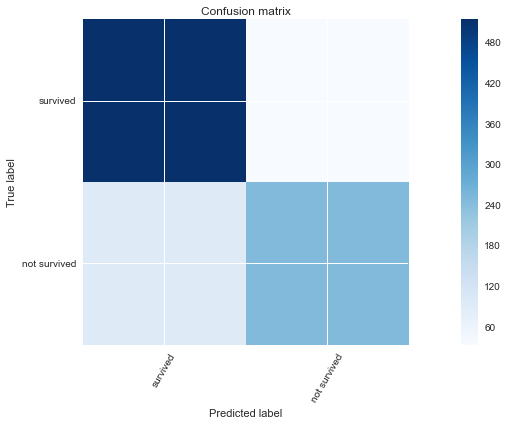

In [23]:
def plot_confusion(cm, target_names = ['survived', 'not survived'],
                   title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Convenience function to adjust plot parameters for a clear layout.
    plt.tight_layout()

plt.figure(figsize=(15, 6))
plot_confusion(cm)

In [49]:
y_test_predicted = rnd.predict(X_test)
predictions = pd.DataFrame(y_test_predicted)
submission = pd.concat([test_ids, predictions], axis=1)
submission.columns = ['PassengerId', 'Survived']
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('rf_all_features.csv', sep = ',', index = False)

In [50]:
x = pd.concat([pd.DataFrame(features), pd.DataFrame(rnd.feature_importances_)], axis = 1)
x.columns = ['feature', 'importance']

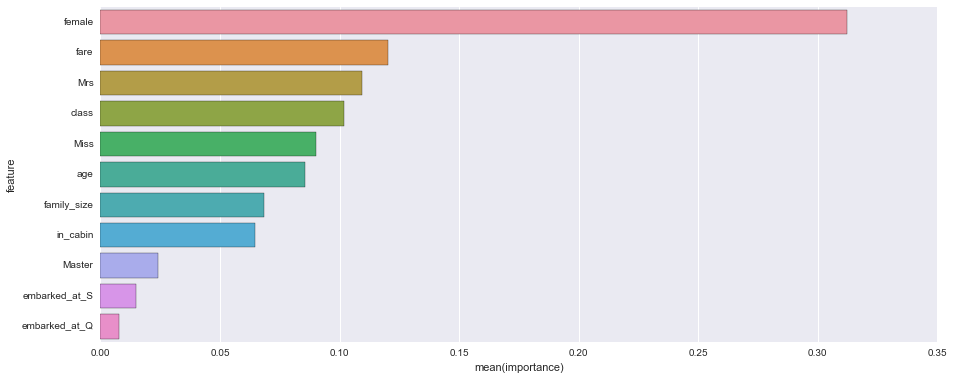

In [51]:
plt.figure(figsize=(15, 6))
sns.barplot(x = 'importance', y = 'feature', data = x.sort('importance', ascending=0))

In [15]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
X_test = StandardScaler().fit_transform(X_test)

In [16]:
rnd = RandomForestClassifier(n_estimators = 1000, max_depth = 5)
rnd.fit(X, y)
y_predicted = rnd.predict(X)
print accuracy_score(y, y_predicted)

0.855218855219


In [17]:
y_test_predicted = rnd.predict(X_test)
predictions = pd.DataFrame(y_test_predicted)
submission = pd.concat([test_ids, predictions], axis=1)
submission.columns = ['PassengerId', 'Survived']
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('rf_scaled.csv', sep = ',', index = False)

**Ada Boost**

In [19]:
scores = [] 
ada = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(), n_estimators=1000, learning_rate= 1.0, algorithm='SAMME.R', random_state=10)
scores = cross_validation.cross_val_score(ada, X, y, cv=5)
print 'Out of fold prediction accuracy: ' + str(round(average(scores), 2))

Out of fold prediction accuracy: 0.79


In [19]:
ada.fit(X, y)
y_test_predicted = ada.predict(X_test)
predictions = pd.DataFrame(y_test_predicted)
submission = pd.concat([test_ids, predictions], axis=1)
submission.columns = ['PassengerId', 'Survived']
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('adaboost.csv', sep = ',', index = False)

**Stacking Of Models**

Simple stacking of the predictions of 5 different classifiers.

In [6]:
log_reg = LogisticRegression(penalty = 'l1', C = 2)
ext = ExtraTreesClassifier(n_estimators=1000, max_depth=5)
ada = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(), n_estimators=1000, learning_rate= 1.0, algorithm='SAMME.R', random_state=10)
rnd = RandomForestClassifier(n_estimators = 1000, max_depth = 5, oob_score=True)
gb = GradientBoostingClassifier(learning_rate=0.1, max_features=0.5, n_estimators=500, max_depth=3, subsample=0.5)

theList = [log_reg, ext, ada, rnd, gb]

outputs = test_ids

for model in theList:
    model.fit(X, y)
    y_test_predicted = model.predict(X_test)
    predictions = pd.DataFrame(y_test_predicted)
    outputs = pd.concat([outputs, predictions], axis = 1)

outputs.columns = ['PassengerId', 'log_reg', 'ext', 'ada', 'rnd', 'gb']

In [7]:
def theVote(row):
    if row['log_reg'] + row['ext'] + row['ada'] + (row['rnd']*3) + row['gb'] >= 4:
        return 1
    else:
        return 0

outputs['Survived'] = outputs.apply(theVote, axis = 1)
outputs[['PassengerId', 'Survived']].to_csv('stacked_1_weighted.csv', sep = ',', index = False)

Use predicted probabilities and called Survived if total is greater than 2.5

In [9]:
log_reg = LogisticRegression(penalty = 'l1', C = 2)
ext = ExtraTreesClassifier(n_estimators=1000, max_depth=5)
ada = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(), n_estimators=1000, learning_rate= 1.0, algorithm='SAMME.R', random_state=10)
rnd = RandomForestClassifier(n_estimators = 1000, max_depth = 5, oob_score=True)
gb = GradientBoostingClassifier(learning_rate=0.1, max_features=0.5, n_estimators=500, max_depth=3, subsample=0.5)

theList = [log_reg, ext, ada, rnd, gb]

outputs = test_ids

for model in theList:
    model.fit(X, y)
    y_test_predicted = model.predict_proba(X_test)
    predictions = pd.DataFrame(y_test_predicted)
    outputs = pd.concat([outputs, predictions], axis = 1)

outputs.columns = ['PassengerId', 'log_reg_0', 'log_reg_1', 'ext_0', 'ext_1', 'ada_0','ada_1', 'rnd_0', 'rnd_1','gb_0', 'gb_1']

In [13]:
def theVote(row):
    if row['log_reg_1'] + row['ext_1'] + row['ada_1'] + (row['rnd_1']*3) + row['gb_1'] >= 3.0:
        return 1
    else:
        return 0

outputs['Survived'] = outputs.apply(theVote, axis = 1)
outputs[['PassengerId', 'Survived']].to_csv('stacked_2_weighted.csv', sep = ',', index = False)

**************************************************************

Create probablistic predictions on training set then use logistic regression to predict test set

In [44]:
log_reg = LogisticRegression(penalty = 'l1', C = 2)
ext = ExtraTreesClassifier(n_estimators=1000, max_depth=5)
ada = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(), n_estimators=1000, learning_rate= 1.0, algorithm='SAMME.R', random_state=10)
rnd = RandomForestClassifier(n_estimators = 1000, max_depth = 5, oob_score=True)
gb = GradientBoostingClassifier(learning_rate=0.1, max_features=0.5, n_estimators=500, max_depth=3, subsample=0.5)

theList = [log_reg, ext, ada, rnd, gb]

outputs = train['id']
outputs_test = test['id']

for model in theList:
    model.fit(X, y)
    y_train_predicted = model.predict_proba(X)
    y_test_predicted = model.predict_proba(X_test)
    predictions = pd.DataFrame(y_train_predicted)
    predictions_test = pd.DataFrame(y_test_predicted)
    outputs = pd.concat([outputs, predictions], axis = 1)
    outputs_test = pd.concat([outputs_test, predictions_test], axis = 1)

outputs.columns = ['PassengerId', 'log_reg_0', 'log_reg_1', 'ext_0', 'ext_1', 'ada_0','ada_1', 'rnd_0', 'rnd_1','gb_0', 'gb_1']
outputs_test.columns = ['PassengerId', 'log_reg_0', 'log_reg_1', 'ext_0', 'ext_1', 'ada_0','ada_1', 'rnd_0', 'rnd_1','gb_0', 'gb_1']

#outputs = pd.concat([outputs, train['survived'].reset_index])

In [ ]:
X_meta = outputs [['log_reg_1', 'ext_1', 'ada_1', 'rnd_1', 'gb_1']]

In [14]:
meta_log_reg = LogisticRegression()
meta_log_reg.fit(X_meta, y)
y_predicted = meta_log_reg.predict(X_meta)
print accuracy_score(y, y_predicted)

NameError: name 'X_meta' is not defined